In [1]:
# class RobotabilityGraph that inherits from Graph class 
import os
import sys 
sys.path.append("/share/ju/urban-fingerprinting")

import osmnx as ox 
import geopandas as gpd 
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
# enable latex plotting 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from glob import glob 
from tqdm import tqdm 

from shapely import wkt, LineString 

import rasterio
from rasterio.enums import Resampling
from rasterio.plot import show 


from src.utils.logger import setup_logger 

logger = setup_logger('robotability-score')
logger.setLevel("INFO")
logger.info("Modules initialized.")

WGS='EPSG:4326'
PROJ='EPSG:2263'

REGEN_SEGMENTIZATION=True
REGEN_TOPOLOGY=True



2024-12-10 01:02:20 - robotability-score - INFO - Modules initialized.


In [18]:
deployments = { 
    'Elmhurst, Queens': {
        'coords': (40.738536, -73.887267),
        'type': 'high',
    },
    'Sutton Place, Manhattan': {
        'coords': (40.758890, -73.958457),
        'type': 'high',
    },
    'Herald Square, Manhattan': {
        'coords': (40.748422, -73.988275),
        'type': 'low',
    },
    'Jackson Heights, Queens': {
        'coords': (40.747379, -73.889690),
        'type': 'low'
    }
}

deployments = pd.DataFrame(deployments).T
deployments = gpd.GeoDataFrame(deployments, geometry=gpd.points_from_xy(deployments['coords'].apply(lambda x: x[1]), deployments['coords'].apply(lambda x: x[0]))).set_crs(WGS).to_crs(PROJ)

In [20]:
deployments

,coords,type,geometry
"Elmhurst, Queens","(40.738536, -73.887267)",high,POINT (1015490.595 208365.563)
"Sutton Place, Manhattan","(40.75889, -73.958457)",high,POINT (995758.840 215763.757)
"Herald Square, Manhattan","(40.748422, -73.988275)",low,POINT (987498.685 211947.398)
"Jackson Heights, Queens","(40.747379, -73.88969)",low,POINT (1014815.068 211586.497)


In [2]:
cbs_nyc = gpd.read_file("../data/nycb2020_24c/nycb2020.shp")
all_cbs_nyc = cbs_nyc.copy()

In [3]:
score_nyc = pd.read_csv("../data/processed/score_nyc.csv", engine='pyarrow')

<Axes: >

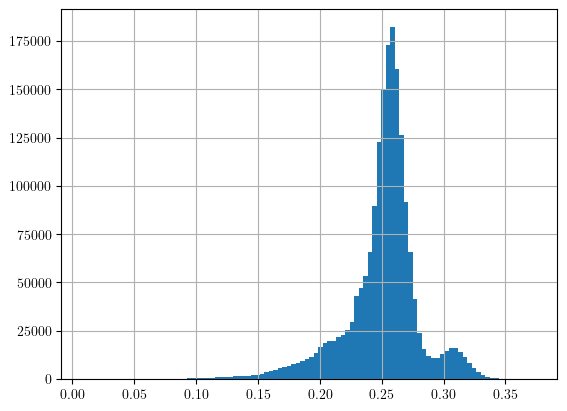

In [4]:
score_nyc['score'].hist(bins=100)

In [5]:
# compute score relative to average in score_rta column 
score_nyc['score_rta'] = score_nyc['score'] / score_nyc['score'].mean()
score_nyc['score_rta'].describe() 

count    1.876414e+06
mean     1.000000e+00
std      1.194239e-01
min      3.697915e-02
25%      9.605110e-01
50%      1.016104e+00
75%      1.056247e+00
max      1.487864e+00
Name: score_rta, dtype: float64

In [6]:
score_nyc['score_percentile'] = score_nyc['score'].rank(pct=True) * 100
score_nyc['score_percentile'].describe()

count    1.876414e+06
mean     5.000003e+01
std      2.886752e+01
min      5.329314e-05
25%      2.500004e+01
50%      5.000003e+01
75%      7.500001e+01
max      1.000000e+02
Name: score_percentile, dtype: float64

In [7]:
score_nyc = gpd.GeoDataFrame(score_nyc, geometry=wkt.loads(score_nyc['geometry']), crs=PROJ)

In [8]:
score_nyc['score'].describe()

count    1.876414e+06
mean     2.511029e-01
std      2.998769e-02
min      9.285569e-03
25%      2.411871e-01
50%      2.551465e-01
75%      2.652265e-01
max      3.736069e-01
Name: score, dtype: float64

In [9]:
# merge score_nyc with cbs_nyc 
by_cb = score_nyc.sjoin(cbs_nyc, how='left', op='intersects')



/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3550: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
score_by_cb = by_cb.groupby('BCTCB2020').agg({'score':'mean', 'score_rta':'mean', 'score_percentile': 'mean'}).reset_index()

In [11]:
score_by_cb['score'].max() / score_by_cb['score'].min()

4.3140190118895845

In [12]:
cbs_nyc = cbs_nyc.merge(score_by_cb, on='BCTCB2020', suffixes=('', '_mean'))

/tmp/ipykernel_3379814/1315295887.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')
/tmp/ipykernel_3379814/1315295887.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_xticklabels([str(int(tick)) + r'\textsuperscript{th}' for tick in cbar.get_xticks()])


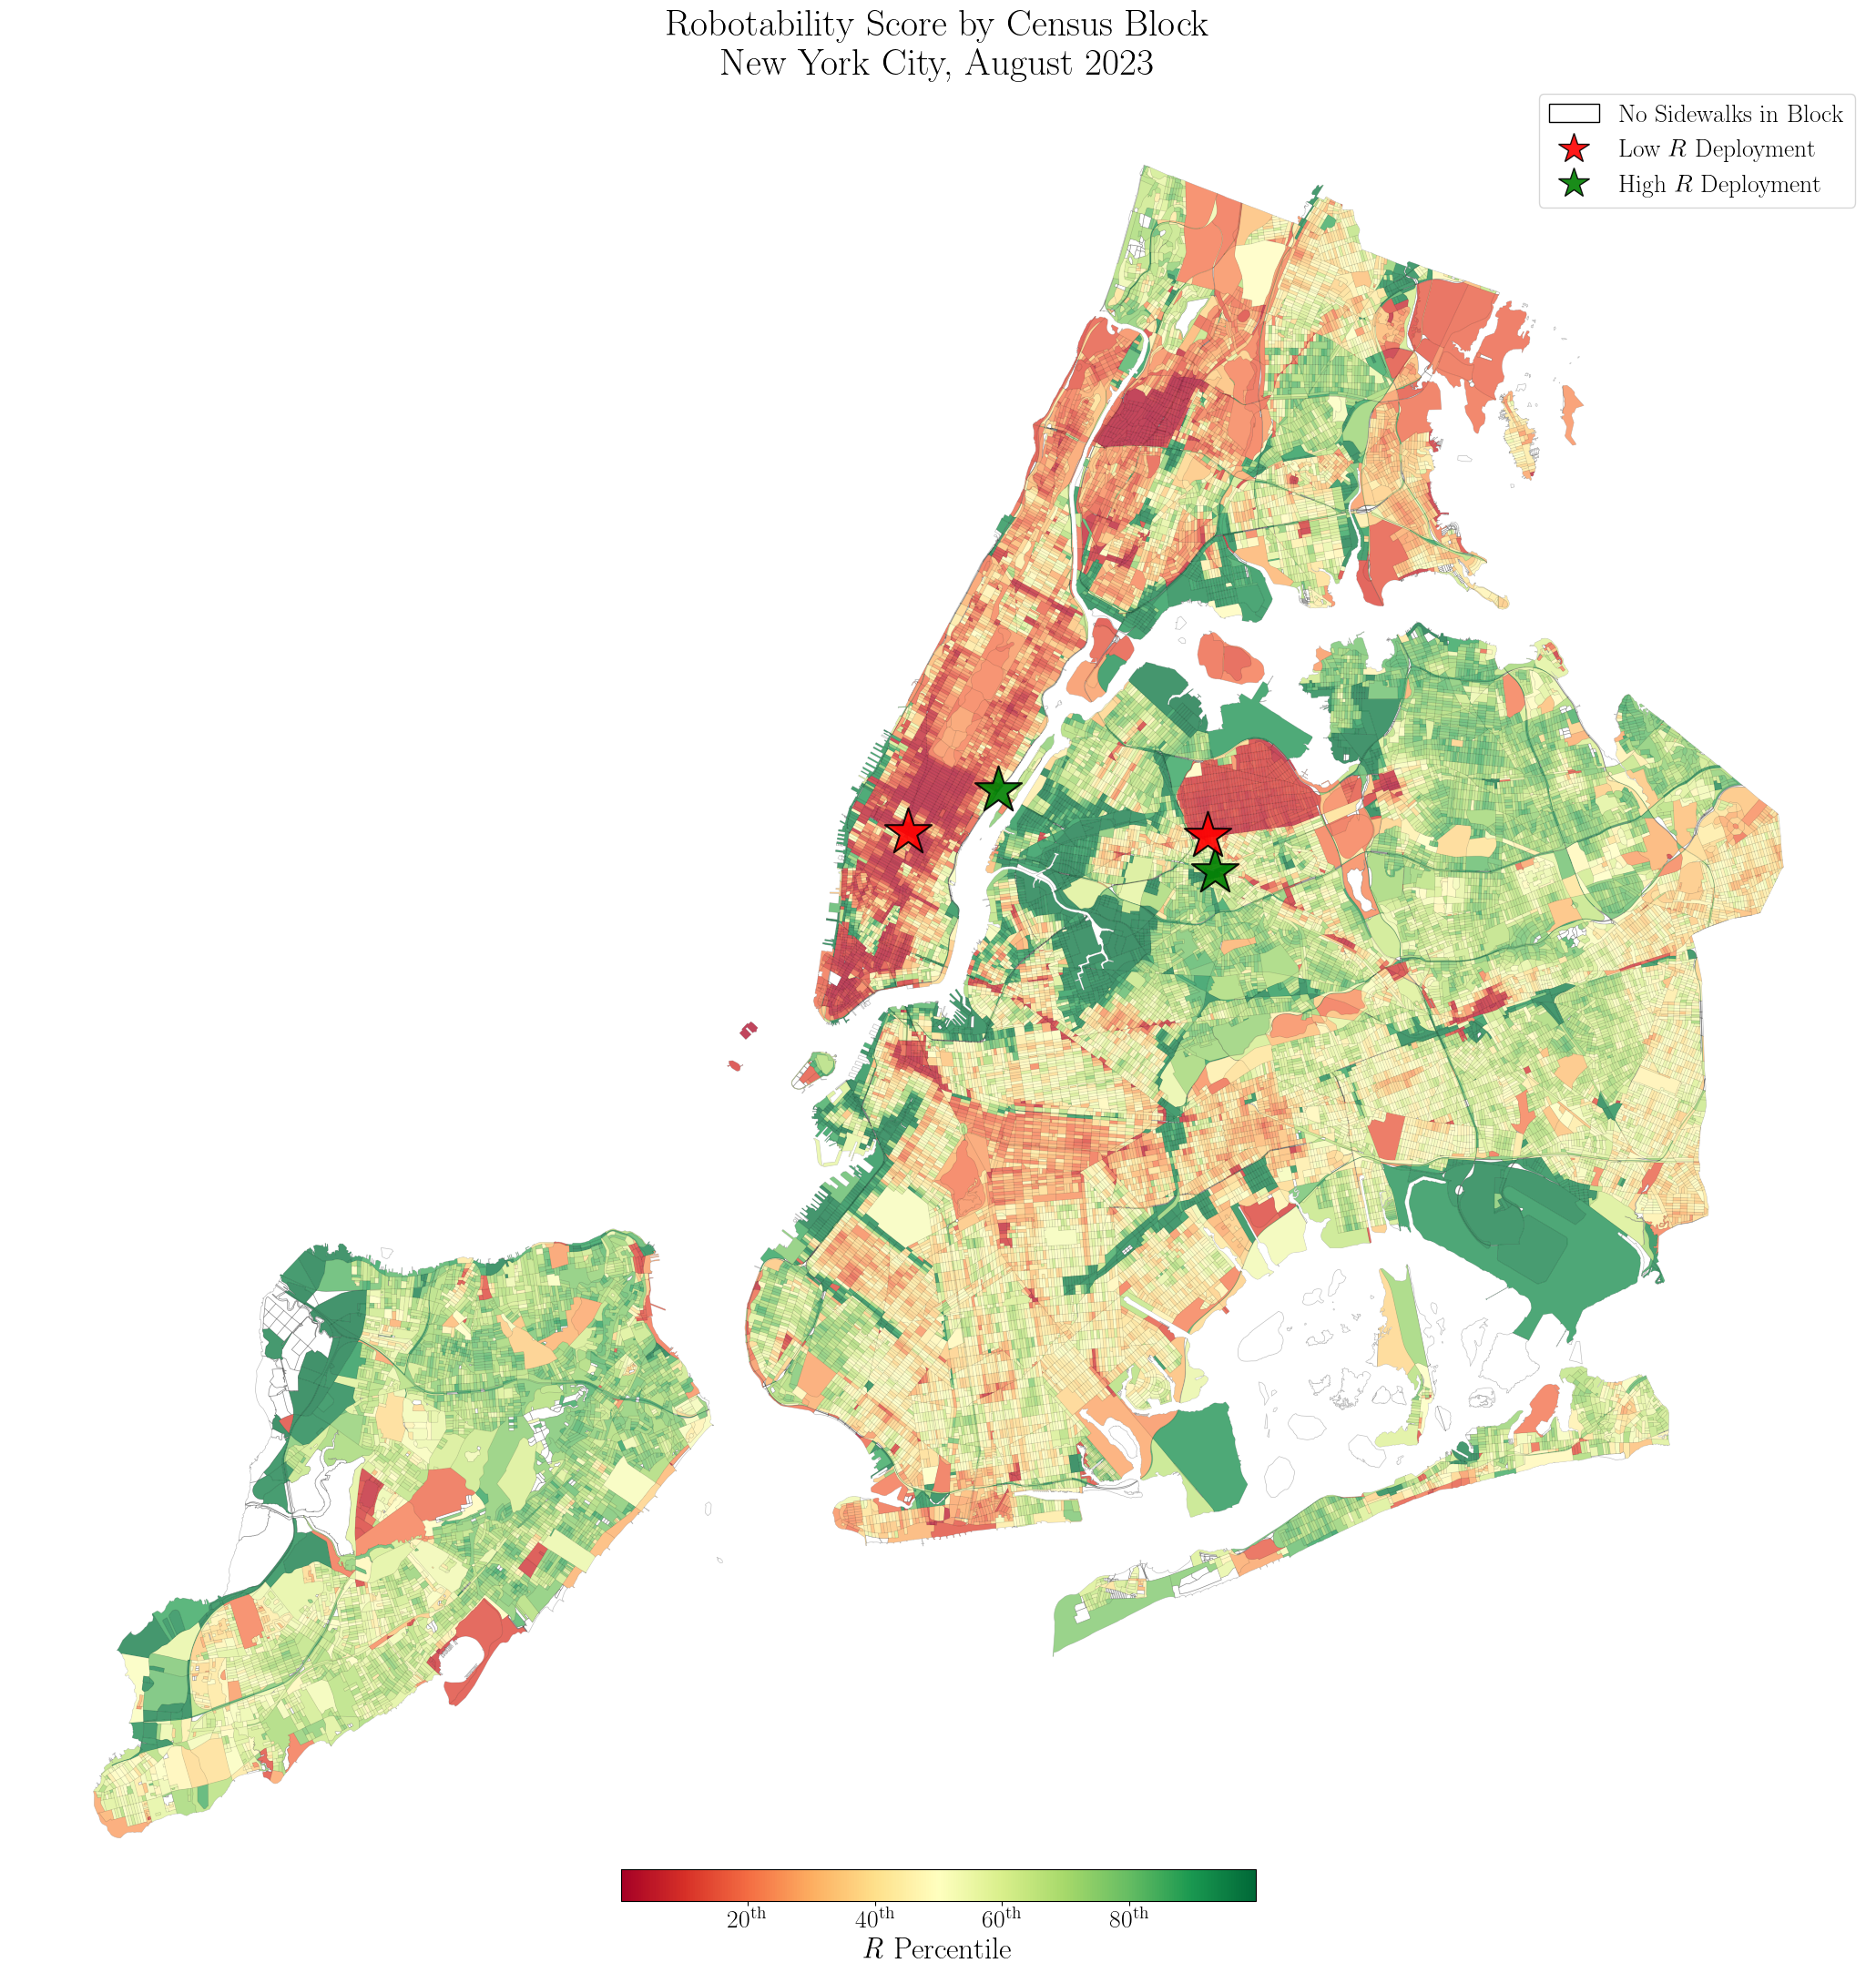

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(30, 30))

# get coolwarm colormap and inverse it 
cmap = plt.cm.get_cmap('RdYlGn')
#cmap = cmap.reversed()

all_cbs_nyc.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.25, zorder=0)
cbs_nyc.plot(column='score_percentile', ax=ax, legend=True, cmap=cmap, legend_kwds={'orientation': "horizontal", 'shrink': 0.3, 'pad': -0.025}, zorder=1, alpha=0.75),

# set colorbar font size 
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=20)
# set label font size on colorbar 
cbar.set_xlabel(r"\textit{R} Percentile", fontsize=24)

# add 'th' to the end of the percentile for each tick label 
cbar.set_xticklabels([str(int(tick)) + r'\textsuperscript{th}' for tick in cbar.get_xticks()])

plt.title("Robotability Score by Census Block" "\n" "New York City, August 2023", fontsize=30)


from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# add red and green markers for high and low deployements
for i, row in deployments.iterrows():
    ax.scatter(row['geometry'].x, row['geometry'].y, 
              color='red' if row['type'] == 'low' else 'green', 
              s=1500, marker='*', zorder=2, 
              edgecolor='black', linewidth=1.5, alpha=0.9)

# Create legend elements with matching markers
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='No Sidewalks in Block'),
    Line2D([0], [0], marker='*', color='red', label=r'Low $R$ Deployment',
           markerfacecolor='red', markersize=25, linestyle='none',
           markeredgecolor='black', markeredgewidth=1, alpha=0.9),
    Line2D([0], [0], marker='*', color='green', label=r'High $R$ Deployment',
           markerfacecolor='green', markersize=25, linestyle='none',
           markeredgecolor='black', markeredgewidth=1, alpha=0.9)
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=20)


ax.set_axis_off()


plt.savefig("../chi24_roving_whiteboards/figures/robotability_score_by_cb.pdf", dpi=300, bbox_inches='tight')